# 4 Visualizing and analyzing cell metric data
**Estimated time to run through notebook is 20 minutes** 

This notebook shows how to
-  [Load libraries, predefine some functions, and load the manifest](#preprocessing)
-  [4.1 Visualize cell metrics in various ways](#visualize)
-  [4.2 Perform statistical analyses on these metric data](#stats)
-  [Conclusion](#end)

We explore the dataset's metrics by focusing on two aspects of the cells in the dataset:
1. In 4.1 we look at mitotic vs. interphase cells
2. In 4.2 we look at edge vs non-edge cells

#### Resources
- pandas for reading and slicing manifests - https://pandas.pydata.org
- matlpotlib for plotting - https://matplotlib.org
- sklearn for statistical analysis - https://scikit-learn.org/


## <a id='preprocessing'></a>Load libraries, predefine some functions, and load the manifest 

### Load libraries and predefined functions

In [1]:
# First "pip install -e ." from command line (when in cytodata-hackathon-base)

import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

### Load the manifest and explore dimensions

In [2]:
df = pd.read_parquet("s3://allencell-cytodata-variance-data/variance-dataset/processed/hackathon_manifest_092022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 78


## <a id='visualize'></a> 4.1 Visualize cell metrics in various ways

In this section, we will visualize distributions of various cell metrics. We will focus on the height and volume of cells and nuclei, as well as the relationship between them across various stages of growth.

### Recap the list of cell metrics

In [3]:
col_df = pd.read_csv("resources/hackathon_column_descriptions.csv",delimiter=",")
col_df.columns = ["column name","description","category"]

df_cell_metrics = df.filter(items=(col_df[col_df.category=="cell metric"]['column name']))
df_cell_metrics.columns

Index(['angle', 'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_min_x',
       'bbox_min_y', 'bbox_min_z', 'bf_clip_hi', 'bf_clip_lo', 'cell_height',
       'cell_surface_area', 'cell_volume', 'dna_clip_hi', 'dna_clip_lo',
       'fits_x', 'fits_y', 'fits_z', 'membrane_clip_hi', 'membrane_clip_lo',
       'nuclear_height', 'nuclear_surface_area', 'nuclear_volume',
       'scale_micron', 'shape_mode_1_height', 'shape_mode_2_volume',
       'shape_mode_3_major_tilt', 'shape_mode_4_minor_tilt',
       'shape_mode_5_elongation', 'shape_mode_6_bean-ness',
       'shape_mode_7_pear-ness', 'shape_mode_8_wedge', 'structure_clip_hi',
       'structure_clip_lo', 'structure_connected_components',
       'structure_volume', 'this_cell_nbr_dist_2d'],
      dtype='object')

### Make a bar plot of the number of cells per structure, stratified based on mitotic cell stage

Note the cell cycle stages annotated within our dataset

In [4]:
print(np.sort(df["cell_stage"].unique()))

['M0' 'M1M2' 'M3' 'M4M5' 'M6M7_complete' 'M6M7_single']


- "M0" - interphase
- "M1/M2" - prophase
- "M3" - early prometaphase
- "M4/M5" - prometaphase/metaphase
- "M6/M7" - anaphase/telophase/cytokinesis

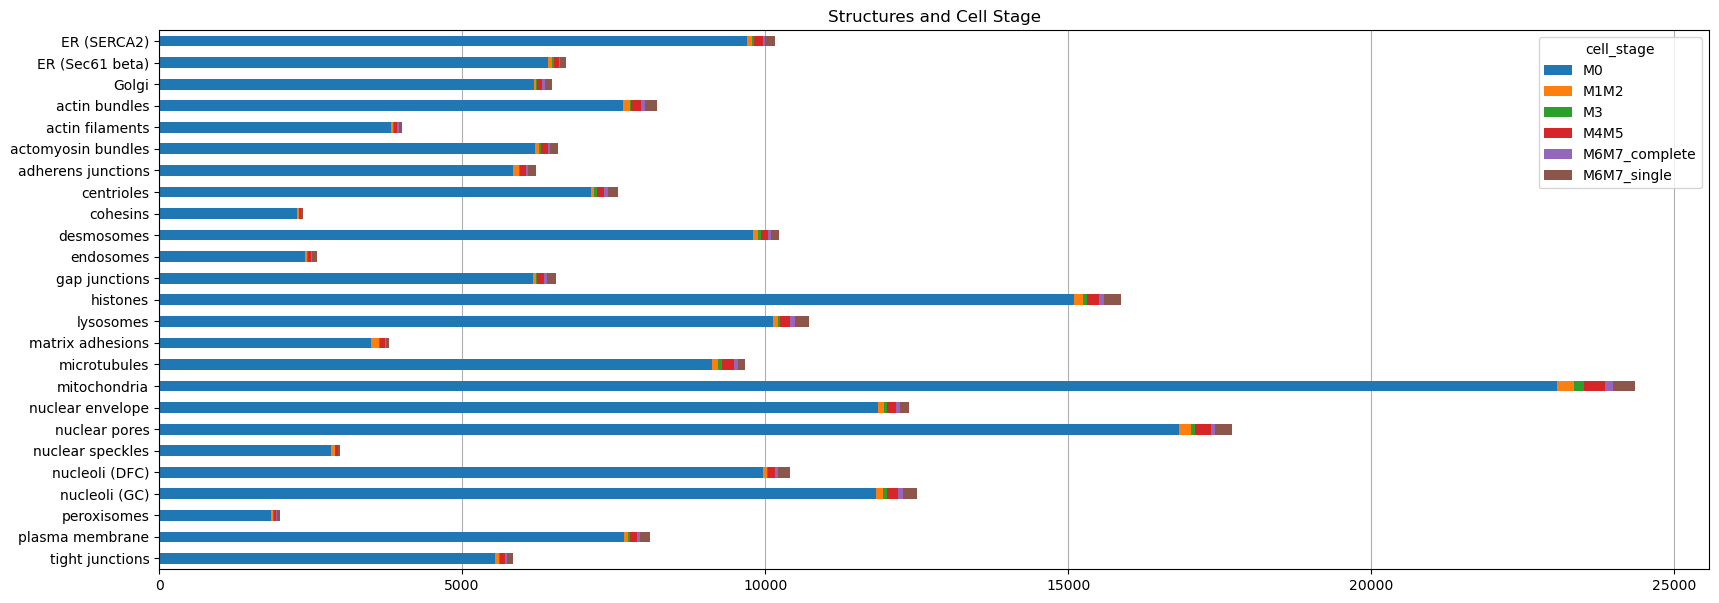

In [5]:
table = pd.pivot_table(df, index="Structure", columns="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

### Plot a histogram for a metric

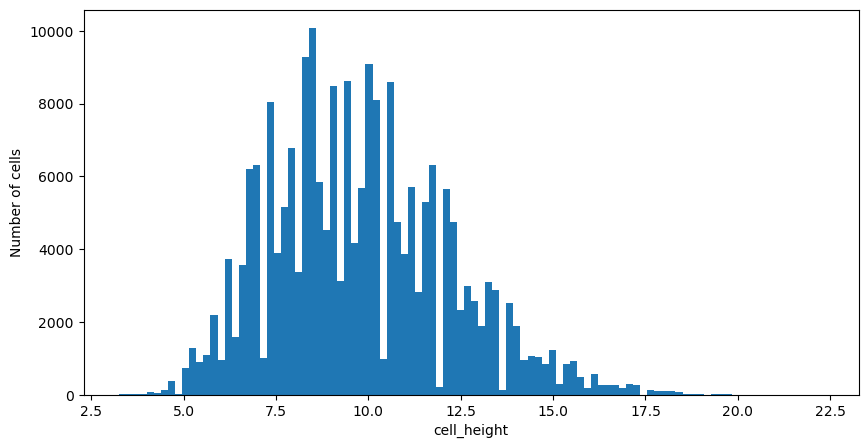

In [6]:
# select the metric 

metric = "cell_height"  # try changing this to cell_volume

fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
axes.hist(df[metric], bins=100)
axes.set_xlabel(metric)
axes.set_ylabel("Number of cells")
plt.show()

*Note the gaps in the height histogram. These indicate the discrete nature of the collected data.*

In [7]:
df["cell_height"].nunique()

147

The plotted histograms include information from cells in all stages of the growth cycle. In the next sub-section, we will stratify these metrics based on the cell cycle stage, and create violin plots to visualize variations between and within cell stages.

### Make a violin plot of a metric for various sub-populations

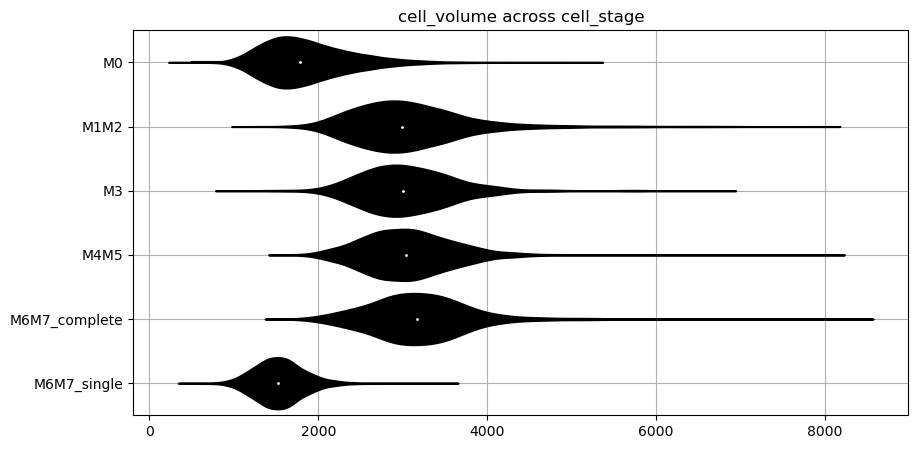

In [8]:
metric = "cell_volume" #  metric to plot
stratifier = "cell_stage" #  name of column whose values are used to define sub-populations

order = np.sort(df[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=df,
    scale="width",
    ax=axes
)

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)

plt.show()

*Note that cells in M6M7_single stage have smaller volumes than other cells, and cells in various mitotic stages have a larger average volume (~ 2x) than interphase cells.* 

The DNA condenses into chromosomes during mitosis, resulting in changes to nuclear shape and size. In the next subsection, we will explore the relationship between the volume of the cell and the volume of the nucleus by visualizing the correlation between these metrics on a scatter plot.

### Create scatterplots to visualize correlation between metrics

#### Plot nuclear volume vs cell volume

The nuclear size scaling principle is a robust empirical relationship which states that the size of the nucleus is linearly proportional to the size of the cell. 

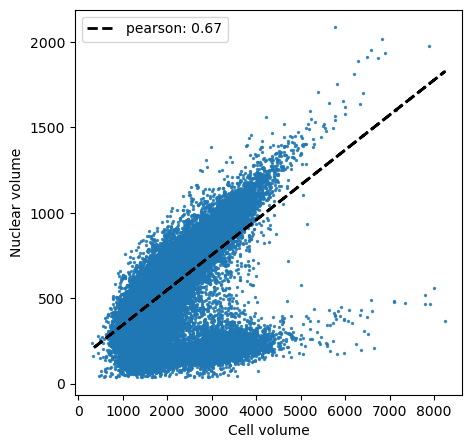

In [9]:
metric_x = df["cell_volume"]  # Cell volume
metric_y = df["nuclear_volume"]  # Nuclear volume

label_x = "Cell volume"
label_y = "Nuclear volume"

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
linear_fit = np.polyfit(metric_x, metric_y, 1)  # calculate linear fit
predict_func = np.poly1d(linear_fit)  # create prediction function from linear fit
pearson_coeff = np.corrcoef(metric_x, metric_y)[0][1]  # calculate pearson correlation coefficient

ax.scatter(metric_x, metric_y, alpha=0.8, s=2)  # create scatter plot for nuclear volume vs cell volume
ax.plot(metric_x, predict_func(metric_x), 'k--', linewidth=2,
        label="pearson: {:.2}".format(pearson_coeff))  # overlay linear fit

ax.set(xlabel=label_x, ylabel=label_y)
ax.legend()
plt.show()


*The Pearson correlation coefficient for these metrics is fairly high, which re-iterates the nuclear size scaling principle.
However, there is a distinct sub-population of nuclei with smaller volumes even when the cell volume is high.* 

In the following section, we will highlight the sub-population of mitotic cells on the scatter plot.

#### Distinguishing sub-populations in the scatter plot

##### Create scatter plot with mitotic cells highlighted in a different color

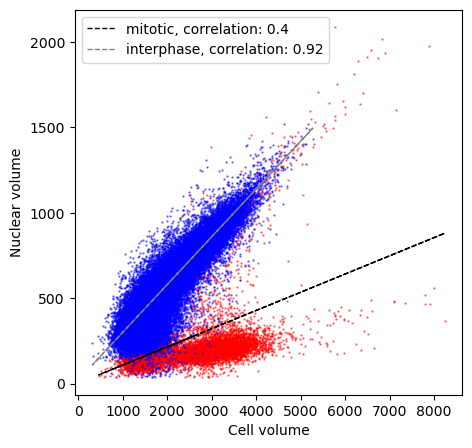

In [10]:
interphase_stage = "M0"

metric_x1 = df[df["cell_stage"] != interphase_stage]["cell_volume"]  # select volumes for mitotic cells
metric_x2 = df[df["cell_stage"] == interphase_stage]["cell_volume"]  # select volumes for interphase cells

metric_y1 = df[df["cell_stage"] != interphase_stage]["nuclear_volume"]  # select volumes for mitotic nuclei
metric_y2 = df[df["cell_stage"] == interphase_stage]["nuclear_volume"]  # select volumes for interphase nuclei

label_x = "Cell volume"
label_y = "Nuclear volume"

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

linear_fit1 = np.polyfit(metric_x1, metric_y1, 1)
pearson_coeff1 = np.corrcoef(metric_x1, metric_y1)[0][1]
predict_func1 = np.poly1d(linear_fit1)

linear_fit2 = np.polyfit(metric_x2, metric_y2, 1)
pearson_coeff2 = np.corrcoef(metric_x2, metric_y2)[0][1]
predict_func2 = np.poly1d(linear_fit2)

ax.scatter(metric_x1, metric_y1, alpha=0.5, s=0.5, c='r')
ax.plot(metric_x1, predict_func1(metric_x1), '--', linewidth=1,
        label=f"mitotic, correlation: {pearson_coeff1:.2}", c='k')

ax.scatter(metric_x2, metric_y2, alpha=0.5, s=0.5, c='b')
ax.plot(metric_x2, predict_func2(metric_x2), '--', linewidth=1,
        label=f"interphase, correlation: {pearson_coeff2:.2}", c='gray')

ax.set(xlabel=label_x, ylabel=label_y)
ax.legend()
plt.show()

*The two sub-populations are clearly separated in the highlighted scatter plot. Note that the mitotic nuclei are usually much smaller than their interphase counterpart*

## <a id='stats'></a>4.2 Perform statistical analyses on these metric data

In this section we will perform statistical analyses on various metrics extracted from our dataset. This section will focus on distinguishing between cells within the center of a colony and those near the edge using various shape metrics.

### Select a subset of cells (1,000 edge cells and 1,000 non-edge cells) and plot some metrics for this subset

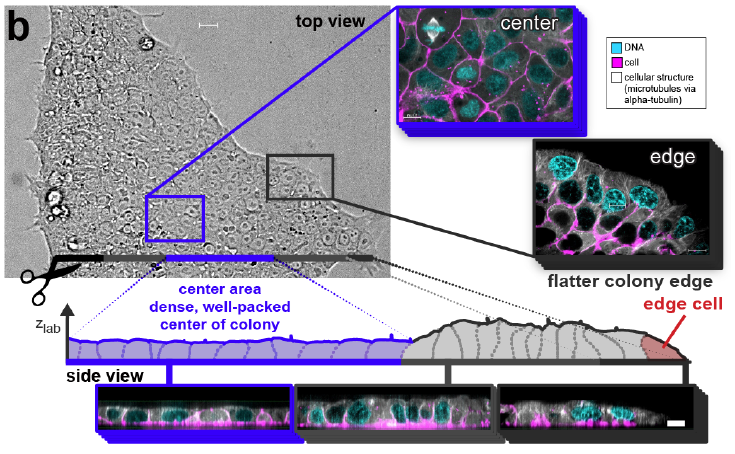 

*Top and side views (single slice) of hiPSCs with FP-tagged microtubules (via alpha-tubulin), grown in tightly packed, epithelial-like colonies and labeled with cell membrane (magenta) and DNA (cyan) dyes to permit imaging and segmenting of cells and nuclei. Cells were most frequently imaged halfway towards the centers of large, well-packed colonies (blue) where they behave most consistently, but were also imaged at other locations within the colony, such as at the edges of colonies (red).*

### Count number of edge and non-edge cells in the dataset

In [11]:
#count edge cells
num_edge = np.count_nonzero(df["edge_flag"] == 1)
#count non-edge cells
num_non_edge = np.count_nonzero(df["edge_flag"] == 0)
#print these numbers
print(f"Number of edge cells: {num_edge}, number of non-edge cells: {num_non_edge}")

Number of edge cells: 5165, number of non-edge cells: 208872


### <a id='sample'></a>Make a dataframe with same number of edge and non-edge cells

In [12]:
n = 1000  #number of cells per class
edge_label = df["edge_flag"].unique()  #labels (binary flag) associated with edge vs. non-edge calls

# Randomly sample cells for each class and add to dataframe
cells_edgeVSnoedge = pd.DataFrame()
for lbl in edge_label:
    cells_edgeVSnoedge = pd.concat([cells_edgeVSnoedge, df[df["edge_flag"]==lbl].sample(n=n)])
print(f'Number of cells: {len(cells_edgeVSnoedge)}')
print(f'Number of columns: {len(cells_edgeVSnoedge.columns)}')  

Number of cells: 2000
Number of columns: 78


### Brief recap: Shape modes

<img align="left" src="resources/shape_modes.png" width=200 />

*Cell (magenta) and nuclear (cyan) shapes in the dataset were parametrized using spherical harmonic expansion (SHE) coefficients. Principal component analysis (PCA) of these coefficient vectors revealed the first 8 principal components (shape modes) explained ~70% of the variance in cell and nuclear shape. Images for volume, elongation, bean-ness and pear-ness depict the top view, whereas other shape modes depict relevant side views.*

### Make a violinplot of a metric comparing edge vs. non-edge cells

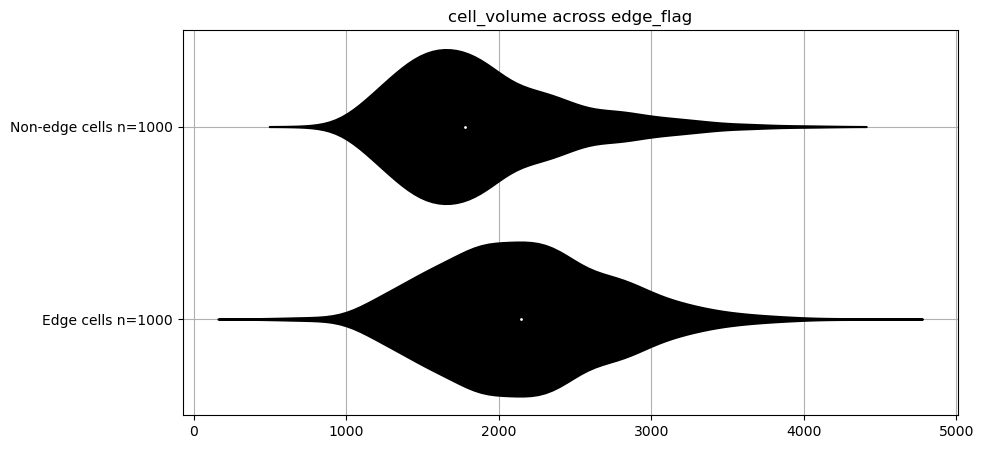

In [13]:
# categorical variable is needed if we want to stratify on that variable
cells_edgeVSnoedge['edge_flag'] = cells_edgeVSnoedge.edge_flag.astype('category')

metric = "cell_volume"  # also try cell_height and shape_mode_3_major_tilt

# select the variable to stratify upon
stratifier = "edge_flag"

# select the order for the categories in the stratifier
order = np.sort(cells_edgeVSnoedge[stratifier].unique())
fig, axes = plt.subplots(figsize=(10, 5), dpi=100)
sns.violinplot(
    y=stratifier,
    x=metric,
    order = order,
    color="black",
    data=cells_edgeVSnoedge,
    scale="width",
    ax=axes
)

yticklabel = [f'Non-edge cells n={n}',f'Edge cells n={n}'] 

axes.set_title(f"{metric} across {stratifier}")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.set_ylabel(None)
axes.set_xlabel(None)
axes.set_yticklabels(yticklabel)
plt.show()

# Need to have more informative ytick-labels indicating edge (1) vs non-edge (0) cells

### Do some statistical tests to see which feature shows the strongest difference between edge and non-edge cells

In [14]:
# Import t-test (test between means) and Kolmogorov-Smirnov test (test comparing entire distributions)
from scipy.stats import ttest_ind,kstest

# Select features to test
selected_features = ['nuclear_volume','nuclear_height','nuclear_surface_area',
                     'cell_volume','cell_height','cell_surface_area',
                     'shape_mode_1_height', 'shape_mode_2_volume',
                     'shape_mode_3_major_tilt', 'shape_mode_4_minor_tilt', 'shape_mode_5_elongation',
                     'shape_mode_6_bean-ness', 'shape_mode_7_pear-ness', 'shape_mode_8_wedge']

# Create two groups (edge cells and non-edge cells)
edge_cells = cells_edgeVSnoedge[cells_edgeVSnoedge['edge_flag']==1]
noedge_cells = cells_edgeVSnoedge[cells_edgeVSnoedge['edge_flag']==0]

# Perform t-test, save t-scores and associated p-values
t_scores = np.empty([len(selected_features),1])
t_pvalues = np.empty([len(selected_features),1])
for i,feature in enumerate(selected_features):
    t_scores[i],t_pvalues[i] = ttest_ind(edge_cells[feature].dropna(), noedge_cells[feature].dropna())

# Perform ks-test, save ks-scores and associated p-values
ks_scores = np.empty([len(selected_features),1])
ks_pvalues = np.empty([len(selected_features),1])
for i,feature in enumerate(selected_features):
    ks_scores[i],ks_pvalues[i] = kstest(edge_cells[feature].dropna(), noedge_cells[feature].dropna())

print("Statistical test complete.")

Statistical test complete.


#### Make plot with test statistics (or associated p-values)

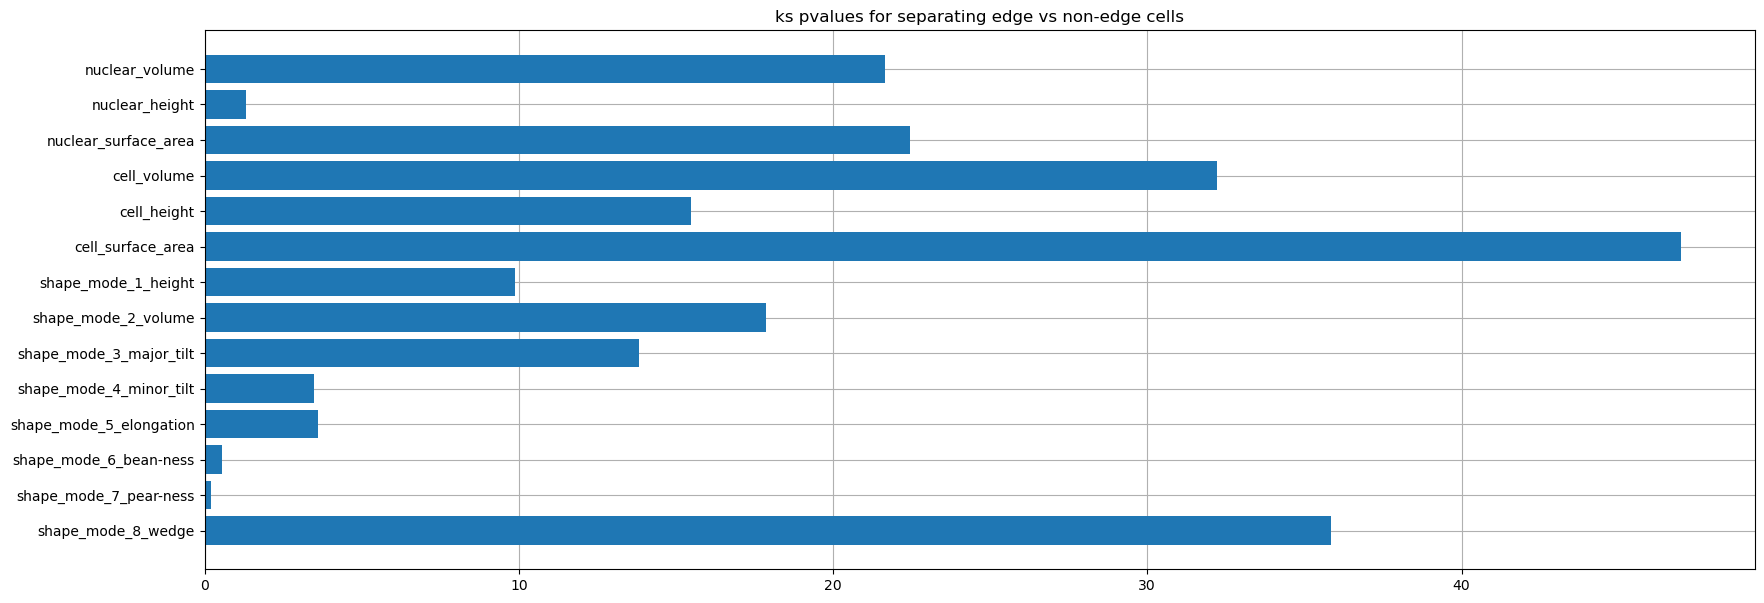

In [15]:
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)

# plot t-test scores
# plt.barh(y = selected_features, width = t_scores.squeeze())
# axes.set_title("t_scores for separating edge vs non-edge cells")

# uncomment following two lines to plot the ks test p values instead
plt.barh(y = selected_features, width = -np.log10(ks_pvalues.squeeze()))
axes.set_title("ks pvalues for separating edge vs non-edge cells")

axes.set_ylabel(None)
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

*Note the difference in scores for shape mode 3 between the t-test and the ks test*

### Build simple classifier (Random Forest out of the box) to discriminate between edge and non-edge cells



In [16]:
# Import RF classifier and confusion matrix functionality
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Initialize classifer
clf = RandomForestClassifier(max_depth=2, random_state=0)

# Make the dataset (features matrix X and class labels y)
Xy = cells_edgeVSnoedge[[*selected_features, 'edge_flag']].dropna(axis=0).to_numpy()
X = Xy[:,0:-1]
y = Xy[:,-1]

# Fit the model
clf.fit(X, y)
# Apply the model (to the training dataset)
y_pred = clf.predict(X)
# Show performance as a confusion matrix
cm = confusion_matrix(y, y_pred)                        

print("Model fitting complete.")

Model fitting complete.


### Visualize the confusion matrix

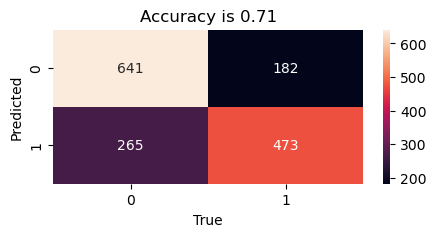

In [17]:
from sklearn.metrics import accuracy_score,classification_report
score = accuracy_score(y,y_pred) #compute accuracy score
cm_df = pd.DataFrame(cm)
fig, axes = plt.subplots(figsize=(5, 2), dpi=100)
sns.heatmap(cm_df, annot=True, fmt='d')
axes.set_title(f'Accuracy is {score:.2f}')
axes.set_xlabel('True')
axes.set_ylabel('Predicted')
plt.show()

#### *Advanced tip: See a brief report of classification metrics*

In [18]:
report = classification_report(y,y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       823
         1.0       0.72      0.64      0.68       738

    accuracy                           0.71      1561
   macro avg       0.71      0.71      0.71      1561
weighted avg       0.71      0.71      0.71      1561



### Look at the importance scores

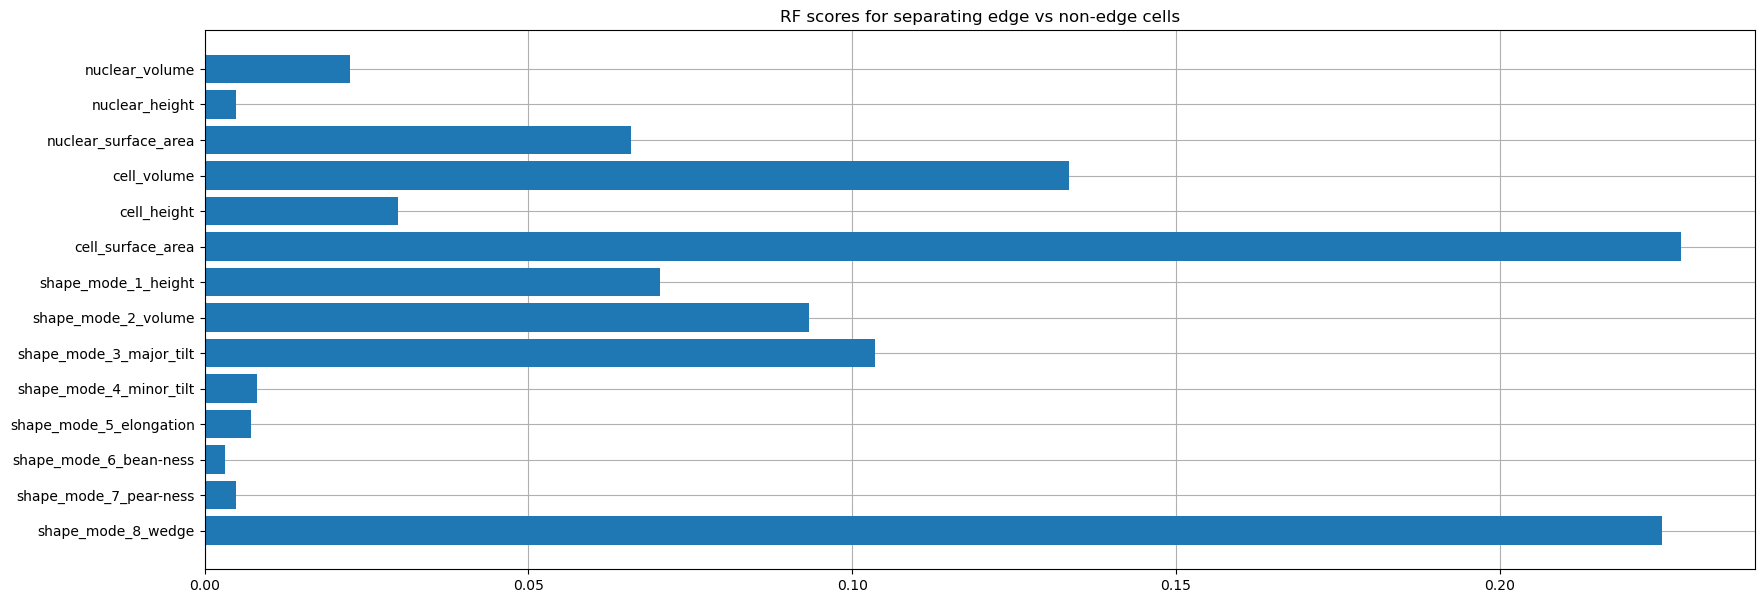

In [19]:
importances = clf.feature_importances_
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
plt.barh(y = selected_features, width = importances.squeeze())
axes.set_ylabel(None)
axes.set_title("RF scores for separating edge vs non-edge cells")
axes.grid(True, which="major", axis="both")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

# <a id='end'></a>Conclusion
In this chapter we made plots and performed simple statistical analyses with the precomputed cellular metrics available in the data manifest. These techniques will be useful while performing the more sophisticated ML analyses that will be covered in Chapter 5